# Introduction

Course: Deep Learing

Author: Oai Tran

Institution: University of Virginia — School of Data Science

Date: 11/07/2025

Notebook Type: Educational / Research — End-to-End Implementation


## Overview
This notebook is the end-to-end process of the final project. The goal of the final project is to predict a stock price and determine whether it is a buy/sell/hold position. 

LKQ


#### Stage 1

In [1]:
# ==========================================================
#  Stage 1 — LKQ Forecast (v2.6)
#  Δ-Target + Conv1D→LSTM + Macro (VIX) | CuDNN-safe & Merge-Safe
# ==========================================================

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import tensorflow as tf
import os
import random
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

from datetime import datetime, timedelta


In [2]:

# ----------------------------------------------------------
# 0. Reproducibility & environment setup
# ----------------------------------------------------------
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_USE_CUDNN_RNN"] = "0"   # disable CuDNN RNN kernels
print("TensorFlow:", tf.__version__)


TensorFlow: 2.17.0


In [3]:

# ----------------------------------------------------------
# 1. Load data (LKQ + VIX)
# ----------------------------------------------------------
start_date, end_date = "2017-01-01", "2025-09-10"

raw = yf.Ticker("LKQ").history(start=start_date, end=end_date, auto_adjust=False)
vix_raw = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)

raw = raw[["Open", "High", "Low", "Close", "Volume"]].dropna()
vix_raw = vix_raw[["Close"]].rename(columns={"Close": "VIX_Close"}).dropna()

# ----------------------------------------------------------
# 1.5 Align and clean data
# ----------------------------------------------------------
# Outer join → keep all dates; forward-fill VIX; drop non-trading days for VOO
df = raw.join(vix_raw, how="outer").sort_index()
df["VIX_Close"] = df["VIX_Close"].fillna(method="ffill")
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

print(f"After merge: {df.shape[0]} rows remain ({df.index.min().date()} → {df.index.max().date()})")



After merge: 2183 rows remain (2017-01-03 → 2025-09-09)


/tmp/ipykernel_459436/1880154230.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["VIX_Close"] = df["VIX_Close"].fillna(method="ffill")


/home/dzn7nf/.local/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


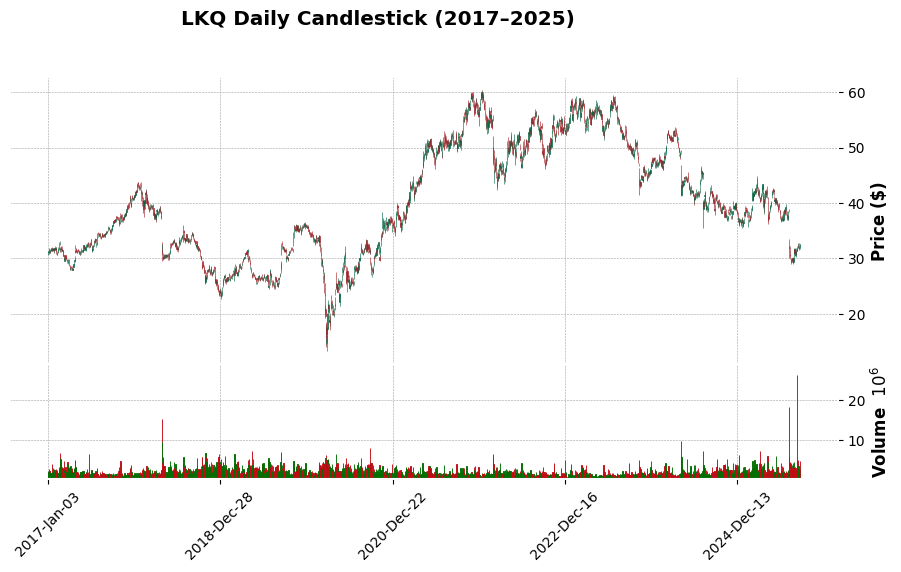

In [4]:
mpf.plot(
    raw,
    type="candle", 
    style="charles",   # clean style
    title="LKQ Daily Candlestick (2017–2025)",
    ylabel="Price ($)",
    volume=True,       # adds volume below chart
    figratio=(12,6)
)

In [5]:
# ----------------------------------------------------------
# 2. Feature engineering
# ----------------------------------------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"] / df["Close"].shift(5) - 1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5, min_periods=1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"]       = (df["VIX_Close"] - df["VIX_Close"].rolling(20, min_periods=1).mean()) / \
                     df["VIX_Close"].rolling(20, min_periods=1).std()
df["VIX_Z"]       = df["VIX_Z"].fillna(0.0)



In [6]:
# ----------------------------------------------------------
# 3. Target = next-day return (Δ target)
# ----------------------------------------------------------
df["TargetRet1"] = (df["Close"].shift(-1) / df["Close"] - 1.0)
df["PrevClose"]  = df["Close"]
df = df.dropna(subset=["TargetRet1"]).copy()


In [7]:
# ----------------------------------------------------------
# 4. Scale features only (not target)
# ----------------------------------------------------------
feature_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Ret1", "Momentum5", "Volatility5", "LogVolume", "VIX_Z"
]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled_features, columns=feature_cols, index=df.index)

y_all      = df["TargetRet1"].values.astype("float32")
prev_close = df["PrevClose"].values.astype("float32")
dates_all  = df.index

print(f"Scaled features shape: {scaled_df.shape}")



Scaled features shape: (2182, 10)


In [8]:
# ----------------------------------------------------------
# 5. Sequence builder
# ----------------------------------------------------------
def make_sequences(X_df, y, prev_close, dates, window=12):
    X, y_out, prev_c, d_out = [], [], [], []
    for i in range(len(X_df) - window):
        X.append(X_df.iloc[i:i+window].values)
        y_out.append(y[i+window-1])           # predict ΔClose for t+1
        prev_c.append(prev_close[i+window-1]) # previous close
        d_out.append(dates[i+window])         # target date
    return np.array(X), np.array(y_out), np.array(prev_c), np.array(d_out)

window = 12
X, y, prev_c, dts = make_sequences(scaled_df, y_all, prev_close, dates_all, window=window)
split = int(len(X)*0.8)

X_tr, X_te = X[:split], X[split:]
y_tr, y_te = y[:split], y[split:]
pc_tr, pc_te = prev_c[:split], prev_c[split:]
dt_tr, dt_te = dts[:split], dts[split:]

print(f"Train: {X_tr.shape},  Test: {X_te.shape}")



Train: (1736, 12, 10),  Test: (434, 12, 10)


In [9]:
# ----------------------------------------------------------
# 6. Conv1D → LSTM model (CuDNN-safe)
# ----------------------------------------------------------
def build_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True, unroll=True,
             activation='tanh', recurrent_activation='sigmoid'),
        Dropout(0.1),
        LSTM(32, unroll=True, activation='tanh', recurrent_activation='sigmoid'),
        Dense(32, activation='relu'),
        Dense(1)  # predict next-day return
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=opt, loss='mse')
    return model

model = build_model((window, X_tr.shape[2]))
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=120,
    batch_size=16,
    verbose=1,
    callbacks=[es]
)



'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


Epoch 1/120


W0000 00:00:1763569476.162323  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569476.179246  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569476.199541  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569476.203511  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569476.226166  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569476.250247  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569476.250592  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569476.277659  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569476.277785  459512 gp

  2/109 [..............................] - ETA: 5s - loss: 0.0014  

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1763569478.949072  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569478.949177  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569478.949241  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569478.949295  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569478.949358  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569478.949422  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569478.949507  459512 gpu_timer.cc:114] Skipping

 36/109 [========>.....................] - ETA: 0s - loss: 6.7657e-04

W0000 00:00:1763569479.088538  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.088620  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.088694  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.088772  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.088850  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.088927  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.089017  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.089099  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.089189  459512 gp

109/109 [==============================] - ETA: 0s - loss: 5.1163e-04

W0000 00:00:1763569479.486430  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.486832  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.486892  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.486967  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.487047  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.487114  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.487187  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.487250  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569479.487318  459512 gp

109/109 [==============================] - 6s 10ms/step - loss: 5.1163e-04 - val_loss: 4.1571e-04
Epoch 2/120
109/109 [==============================] - 0s 4ms/step - loss: 5.0071e-04 - val_loss: 4.1149e-04
Epoch 3/120
 18/109 [===>..........................] - ETA: 0s - loss: 4.0415e-04

W0000 00:00:1763569480.391586  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.391977  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.392035  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.392111  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.392191  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.392267  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.392341  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.392408  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.392478  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 5.0239e-04 - val_loss: 4.6396e-04
Epoch 4/120
 31/109 [=======>......................] - ETA: 0s - loss: 4.6608e-04

W0000 00:00:1763569480.862164  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.862257  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.862330  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.862395  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.862473  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.862540  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.862605  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.862671  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569480.862739  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 5.0126e-04 - val_loss: 4.1016e-04
Epoch 5/120
 34/109 [========>.....................] - ETA: 0s - loss: 5.7995e-04

W0000 00:00:1763569481.350941  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.351441  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.351539  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.351606  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.351686  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.351752  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.351818  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.351884  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.351953  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.9801e-04 - val_loss: 4.3082e-04
Epoch 6/120
 12/109 [==>...........................] - ETA: 0s - loss: 3.0615e-04

W0000 00:00:1763569481.788885  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.788982  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.789057  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.789125  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.789197  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.789264  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.789331  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.789397  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569481.789474  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.9572e-04 - val_loss: 4.0671e-04
Epoch 7/120
 29/109 [======>.......................] - ETA: 0s - loss: 4.5261e-04

W0000 00:00:1763569482.285730  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.285826  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.285904  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.285975  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.286047  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.286117  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.286184  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.286251  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.286320  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 5.0044e-04 - val_loss: 4.0644e-04
Epoch 8/120
 18/109 [===>..........................] - ETA: 0s - loss: 3.4072e-04

W0000 00:00:1763569482.722575  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.722950  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.723029  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.723096  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.723168  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.723235  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.723301  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.723367  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569482.723436  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.9742e-04 - val_loss: 4.1446e-04
Epoch 9/120
 33/109 [========>.....................] - ETA: 0s - loss: 4.1953e-04

W0000 00:00:1763569483.201015  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.201111  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.201186  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.201252  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.201323  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.201390  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.201461  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.201529  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.201598  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.9881e-04 - val_loss: 4.1516e-04
Epoch 10/120
 34/109 [========>.....................] - ETA: 0s - loss: 4.0782e-04

W0000 00:00:1763569483.615039  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.615135  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.615210  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.615276  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.615347  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.615414  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.615480  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.615548  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569483.615617  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.9896e-04 - val_loss: 4.1581e-04
Epoch 11/120
 35/109 [========>.....................] - ETA: 0s - loss: 4.5037e-04

W0000 00:00:1763569484.067089  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.067186  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.067259  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.067326  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.067397  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.067471  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.067537  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.067603  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.067673  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.9406e-04 - val_loss: 4.0875e-04
Epoch 12/120
 35/109 [========>.....................] - ETA: 0s - loss: 5.7326e-04

W0000 00:00:1763569484.481316  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.481694  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.481774  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.481841  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.481913  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.481980  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.482045  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.482112  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.482181  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 5.0700e-04 - val_loss: 4.7199e-04
Epoch 13/120
 18/109 [===>..........................] - ETA: 0s - loss: 3.4422e-04

W0000 00:00:1763569484.892153  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.892247  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.892321  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.892387  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.892465  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.892532  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.892597  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.892664  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569484.892732  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.9717e-04 - val_loss: 4.2341e-04
Epoch 14/120
 28/109 [======>.......................] - ETA: 0s - loss: 6.4117e-04

W0000 00:00:1763569485.342186  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.342282  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.342357  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.342424  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.342501  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.342568  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.342634  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.342701  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.342769  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.9863e-04 - val_loss: 4.0647e-04
Epoch 15/120
 27/109 [======>.......................] - ETA: 0s - loss: 5.5269e-04

W0000 00:00:1763569485.782487  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.782586  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.782660  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.782727  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.782798  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.782868  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.782934  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.783001  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569485.783069  459512 gp

109/109 [==============================] - 0s 4ms/step - loss: 5.0136e-04 - val_loss: 4.0646e-04


W0000 00:00:1763569486.235873  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.235968  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.236042  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.236108  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.236180  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.236246  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.236311  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.236378  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.236446  459512 gp

In [10]:
# ----------------------------------------------------------
# 7. Predict → reconstruct prices
# ----------------------------------------------------------
y_pred_ret = model.predict(X_te).flatten()
y_pred_price = pc_te * (1.0 + y_pred_ret)
y_true_price = pc_te * (1.0 + y_te)

# ----------------------------------------------------------
# 8. Metrics
# ----------------------------------------------------------
mape = np.mean(np.abs((y_true_price - y_pred_price) / y_true_price)) * 100
mae  = mean_absolute_error(y_true_price, y_pred_price)
rmse = mean_squared_error(y_true_price, y_pred_price, squared=False)
r2   = r2_score(y_true_price, y_pred_price)

print(f"MAPE={mape:.2f}% | MAE=${mae:.2f} | RMSE=${rmse:.2f} | R²={r2:.3f}")



14/14 [==============================] - 0s 4ms/step
MAPE=1.25% | MAE=$0.51 | RMSE=$0.84 | R²=0.974


W0000 00:00:1763569486.573754  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.573843  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.573899  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.573972  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.574057  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.574122  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.574196  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.574266  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569486.574335  459512 gp

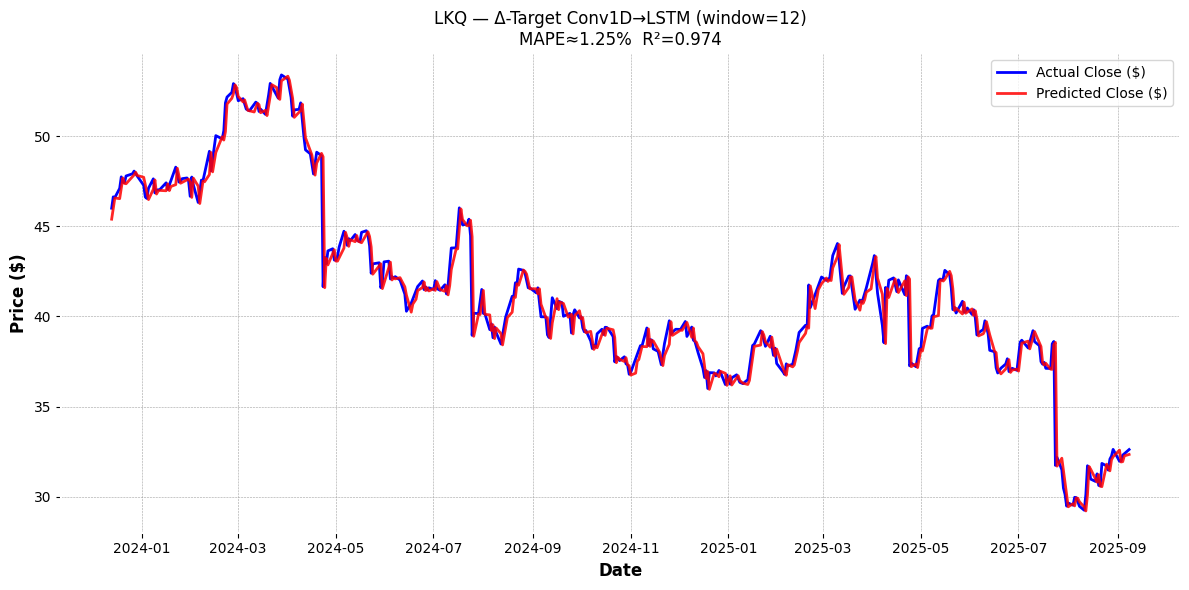

In [11]:
# ----------------------------------------------------------
# 8. Plot results
# ----------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(dt_te, y_true_price, label="Actual Close ($)", color="blue")
plt.plot(dt_te, y_pred_price, label="Predicted Close ($)", color="red", alpha=0.85)
plt.title(f"LKQ — Δ-Target Conv1D→LSTM (window={window})\nMAPE≈{mape:.2f}%  R²={r2:.3f}")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# 9. Save model + scaler
# ----------------------------------------------------------
os.makedirs("models", exist_ok=True)
model.save("models/LKQ_stage1_v26.h5")
joblib.dump(scaler, "models/LKQ_scaler_v26.pkl")
print("Model & scaler saved to ./models/")

Model & scaler saved to ./models/


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Stage 2

W0000 00:00:1763569487.488839  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569487.488926  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569487.488980  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569487.489053  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569487.489139  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569487.489204  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569487.489276  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569487.489346  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569487.489416  459512 gp

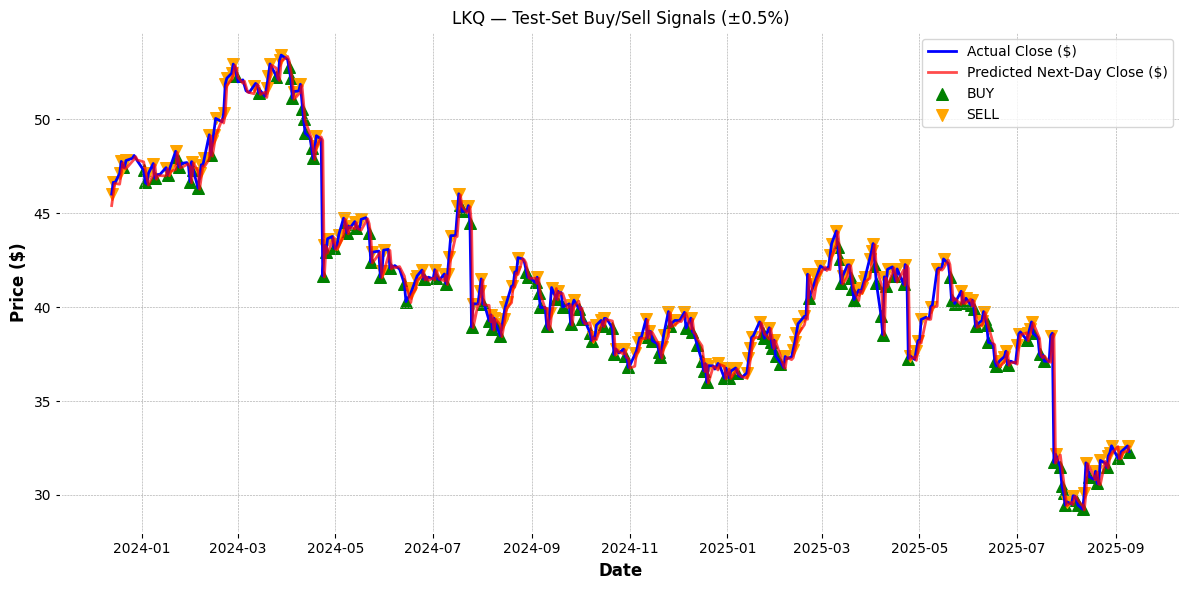

=== TEST-SET RESULTS ===
Strategy  → CAGR -77.93%, Vol 24.82%, Sharpe -3.14
Buy&Hold → CAGR -17.95%, Vol 31.99%, Sharpe -0.56


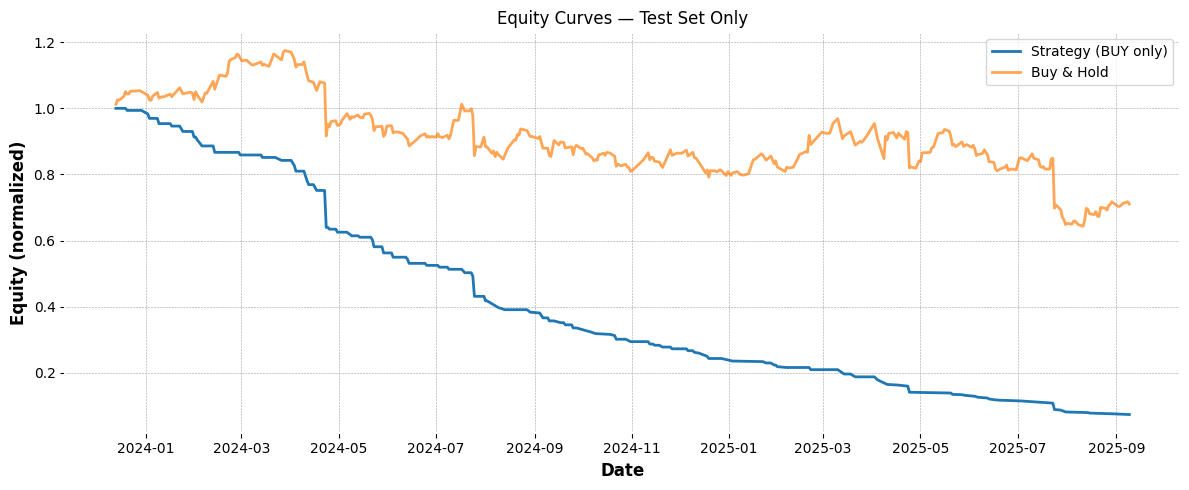


Recent test-period signals:
                              Actual  Predicted    Gap(%) Signal
2025-08-26 04:00:00+00:00  31.469999  31.658846  0.600086    BUY
2025-08-27 04:00:00+00:00  32.080002  31.429138 -2.028878   SELL
2025-08-28 04:00:00+00:00  32.250000  32.038354 -0.656267   SELL
2025-08-29 04:00:00+00:00  32.619999  32.208160 -1.262534   SELL
2025-09-02 04:00:00+00:00  31.959999  32.577683  1.932678    BUY
2025-09-03 04:00:00+00:00  31.980000  31.918570 -0.192088   HOLD
2025-09-04 04:00:00+00:00  32.299999  31.938260 -1.119934   SELL
2025-09-05 04:00:00+00:00  32.380001  32.257740 -0.377581   HOLD
2025-09-08 04:00:00+00:00  32.610001  32.337777 -0.834787   SELL
2025-09-09 04:00:00+00:00  32.310001  32.567305  0.796359    BUY
Saved: artifacts/stage2_signals_LKQ.csv
Saved: models/stage2_config_LKQ.pkl
Saved placeholder model: models/stage2_direct_signal_placeholder_LKQ.h5


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# ==========================================================
#  Stage 2 (Direct Signal, Test Only)
#  v2.4 — Plot & Backtest only on Stage-1 test split
# ==========================================================




# ----------------------------
# Config
# ----------------------------
TICKER = "LKQ"
#START, END = "2017-01-01", "2025-09-10"
WINDOW = 12
THRESH = 0.005   # 0.5% price gap threshold for Buy/Sell
TEST_RATIO = 0.2


# ----------------------------
# Load price data ( + VIX)
# ----------------------------
voo = yf.Ticker(TICKER).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)
voo = voo[["Open","High","Low","Close","Volume"]].dropna()
vix = vix[["Close"]].rename(columns={"Close":"VIX_Close"}).dropna()

df = voo.join(vix, how="outer").sort_index()
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df.dropna(subset=["Open","High","Low","Close","Volume"]).copy()

# ----------------------------
# Load Stage-1 model + scaler
# ----------------------------
model_path = "models/LKQ_stage1_v26.h5"
scaler_path = "models/LKQ_scaler_v26.pkl"
assert os.path.exists(model_path), "Stage-1 model not found!"
assert os.path.exists(scaler_path), "Stage-1 scaler not found!"

model = tf.keras.models.load_model(model_path, compile=False)
scaler = joblib.load(scaler_path)

# ----------------------------
# Feature engineering (same schema)
# ----------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"]/df["Close"].shift(5)-1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5,1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"] = (df["VIX_Close"] - df["VIX_Close"].rolling(20,1).mean()) / df["VIX_Close"].rolling(20,1).std()
df["VIX_Z"] = df["VIX_Z"].fillna(0.0)

feature_cols = [
    "Open","High","Low","Close","Volume",
    "Ret1","Momentum5","Volatility5","LogVolume","VIX_Z"
]
scaled = scaler.transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols, index=df.index)

# ----------------------------
# Build rolling input windows
# ----------------------------
def make_seq(Xdf, window=WINDOW):
    Xs, dates = [], []
    for i in range(len(Xdf)-window):
        Xs.append(Xdf.iloc[i:i+window].values)
        dates.append(Xdf.index[i+window])
    return np.array(Xs), np.array(dates)

Xseq, dates = make_seq(scaled_df, window=WINDOW)
pred_ret = model.predict(Xseq, verbose=0).flatten()

# ----------------------------
# Reconstruct predicted prices
# ----------------------------
close_vals = df["Close"].values
pred_price = close_vals[WINDOW-1:-1] * (1 + pred_ret)
actual_price = close_vals[WINDOW:]
dates = np.array(dates)

# ----------------------------
# Split train/test (chronological)
# ----------------------------
split_idx = int(len(pred_price)*(1-TEST_RATIO))
pred_price_test = pred_price[split_idx:]
actual_price_test = actual_price[split_idx:]
dates_test = dates[split_idx:]

# ----------------------------
# Generate BUY / SELL / HOLD on test only
# ----------------------------
gap = (pred_price_test - actual_price_test) / actual_price_test
signals = np.zeros_like(pred_price_test)
signals[gap > THRESH]  = 1    # BUY
signals[gap < -THRESH] = -1   # SELL
signal_labels = np.where(signals==1,"BUY",np.where(signals==-1,"SELL","HOLD"))

df_signals = pd.DataFrame({
    "Actual": actual_price_test,
    "Predicted": pred_price_test,
    "Gap(%)": gap*100,
    "Signal": signal_labels
}, index=dates_test)

# ----------------------------
# Plot (TEST only)
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(df_signals.index, df_signals["Actual"], label="Actual Close ($)", color="blue")
plt.plot(df_signals.index, df_signals["Predicted"], label="Predicted Next-Day Close ($)", color="red", alpha=0.7)
plt.scatter(df_signals.index[df_signals["Signal"]=="BUY"], df_signals["Actual"][df_signals["Signal"]=="BUY"], 
            marker="^", color="green", label="BUY", s=70)
plt.scatter(df_signals.index[df_signals["Signal"]=="SELL"], df_signals["Actual"][df_signals["Signal"]=="SELL"], 
            marker="v", color="orange", label="SELL", s=70)
plt.title(f"{TICKER} — Test-Set Buy/Sell Signals (±{THRESH*100:.1f}%)")
plt.xlabel("Date"); plt.ylabel("Price ($)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ----------------------------
# Simple backtest (TEST only)
# ----------------------------
returns = pd.Series(df["Close"]).pct_change().reindex(df_signals.index).fillna(0)
positions = np.where(df_signals["Signal"]=="BUY", 1.0, 0.0)
strategy_returns = returns * positions
eq_curve = (1 + strategy_returns).cumprod()
bh_curve = (1 + returns).cumprod()

def ann_metrics(r):
    cagr = (1.0 + r).prod() ** (252/len(r)) - 1.0
    vol  = r.std() * np.sqrt(252)
    sharpe = cagr/vol if vol>0 else 0
    return cagr, vol, sharpe

cagr_s, vol_s, sh_s = ann_metrics(strategy_returns)
cagr_b, vol_b, sh_b = ann_metrics(returns)

print(f"=== TEST-SET RESULTS ===")
print(f"Strategy  → CAGR {cagr_s:.2%}, Vol {vol_s:.2%}, Sharpe {sh_s:.2f}")
print(f"Buy&Hold → CAGR {cagr_b:.2%}, Vol {vol_b:.2%}, Sharpe {sh_b:.2f}")

plt.figure(figsize=(12,5))
plt.plot(eq_curve.index, eq_curve.values, label="Strategy (BUY only)")
plt.plot(bh_curve.index, bh_curve.values, label="Buy & Hold", alpha=0.7)
plt.title("Equity Curves — Test Set Only")
plt.xlabel("Date"); plt.ylabel("Equity (normalized)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

print("\nRecent test-period signals:")
print(df_signals.tail(10))


os.makedirs("models", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

# 1 Save signal dataframe (test predictions)
df_signals.to_csv("artifacts/stage2_signals_LKQ.csv")
print("Saved: artifacts/stage2_signals_LKQ.csv")

# 2 Save the rule parameters as a tiny dict (so we can reload later)
stage2_config = {
    "ticker": TICKER,
    "window": WINDOW,
    "threshold": THRESH,
    "test_ratio": TEST_RATIO,
    "feature_cols": feature_cols,
    "metrics": {
        "strategy_cagr": float(cagr_s),
        "strategy_vol":  float(vol_s),
        "strategy_sharpe": float(sh_s)
    }
}
joblib.dump(stage2_config, "models/stage2_config_LKQ.pkl")
print("Saved: models/stage2_config_LKQ.pkl")

# 3 Optional: save a lightweight “direct-signal model” placeholder
# (just to mark this stage so ensemble loader can find it)
placeholder = Sequential([Dense(1, input_shape=(1,))])
placeholder.save("models/stage2_direct_signal_placeholder_LKQ.h5")
print("Saved placeholder model: models/stage2_direct_signal_placeholder_LKQ.h5")



In [14]:
# ==========================================================
#  Stage 2 — CNN + SVM Training and Save
# ==========================================================

# ----------------------------
# Config
# ----------------------------
#TICKER = "VOO"
#START, END = "2017-01-01", "2025-09-10"
WINDOW = 7
EPOCHS, BATCH = 40, 32
os.makedirs("models", exist_ok=True)

# ----------------------------
# Load LW + VIX
# ----------------------------
voo = yf.Ticker(TICKER).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)
df = voo.join(vix[["Close"]].rename(columns={"Close":"VIX_Close"}), how="outer")
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df[["Open","High","Low","Close","Volume","VIX_Close"]].dropna()

# ----------------------------
# Feature engineering
# ----------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"]/df["Close"].shift(5)-1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5,1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"]       = (df["VIX_Close"]-df["VIX_Close"].rolling(20,1).mean())/df["VIX_Close"].rolling(20,1).std()
df["VIX_Z"]       = df["VIX_Z"].fillna(0.0)

features = ["Open","High","Low","Close","Volume","Ret1","Momentum5",
            "Volatility5","LogVolume","VIX_Z"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features, index=df.index)

# ----------------------------
# Build CNN “images” and labels
# ----------------------------
def make_seq(df_scaled, horizon=1, window=WINDOW):
    X, y = [], []
    closes = df["Close"].values
    for i in range(len(df_scaled)-window-horizon):
        X.append(df_scaled.iloc[i:i+window].values.T)
        fwd_ret = (closes[i+window+horizon-1]-closes[i+window-1]) / closes[i+window-1]
        y.append(1 if fwd_ret>0 else 0)  # 1=Up, 0=Down
    return np.array(X), np.array(y)

X, y = make_seq(scaled_df)
X = X[..., np.newaxis]
print("Dataset:", X.shape, y.shape)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, shuffle=False)

# ----------------------------
# CNN model
# ----------------------------
inp = Input(shape=(X.shape[1], X.shape[2], 1))
x = Conv2D(32, (3,3), padding="same", activation="relu")(inp)
x = BatchNormalization()(x)
x = MaxPooling2D((1,2))(x)
x = Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1,2))(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(2, activation="softmax")(x)

cnn = Model(inp, out)
cnn.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
es = EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
cnn.fit(Xtr, ytr, validation_data=(Xte, yte),
        epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=1)

cnn.save("models/stage2_cnn_LKQ.h5")
print("Saved: models/stage2_cnn_LKQ.h5")

# ----------------------------
# SVM on CNN embeddings
# ----------------------------
embed_model = Model(inputs=cnn.input, outputs=cnn.layers[-3].output)
emb_tr = embed_model.predict(Xtr, verbose=0)
emb_te = embed_model.predict(Xte, verbose=0)

svm = SVC(kernel="rbf", probability=True)
svm.fit(emb_tr, ytr)
acc = svm.score(emb_te, yte)
print(f"SVM accuracy: {acc:.3f}")
joblib.dump(svm, "models/stage2_svm_LKQ.pkl")
print("Saved: models/stage2_svm_LKQ.pkl")


Dataset: (2174, 10, 7, 1) (2174,)
Epoch 1/40


W0000 00:00:1763569489.150470  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.151315  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.154320  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.154421  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.154500  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.154579  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.154645  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.154749  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.177984  459512 gp

32/55 [================>.............] - ETA: 0s - loss: 0.9589 - accuracy: 0.4844

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1763569489.830191  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.830288  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.830358  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.830454  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.830523  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.830614  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569489.830679  459512 gpu_timer.cc:114] Skipping

52/55 [===========================>..] - ETA: 0s - loss: 0.8595 - accuracy: 0.4976

W0000 00:00:1763569490.042530  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.042619  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.042676  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.042746  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.042818  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.042906  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.042982  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.043066  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.043146  459512 gp

55/55 [==============================] - 2s 9ms/step - loss: 0.8526 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 2/40
55/55 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5244

W0000 00:00:1763569490.289499  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.289588  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.289646  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.289718  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.289783  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.289872  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.289948  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.290038  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.290119  459512 gp

55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5244 - val_loss: 0.6954 - val_accuracy: 0.5011
Epoch 3/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.5313 - val_loss: 0.6989 - val_accuracy: 0.5011
Epoch 4/40
 1/55 [..............................] - ETA: 0s - loss: 0.6684 - accuracy: 0.5938

W0000 00:00:1763569490.524441  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.524536  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.524594  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.524667  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.524733  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.524822  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.524898  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.524987  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.525067  459512 gp

55/55 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5227 - val_loss: 0.7019 - val_accuracy: 0.5011
Epoch 5/40
43/55 [======================>.......] - ETA: 0s - loss: 0.6858 - accuracy: 0.5378

W0000 00:00:1763569490.865453  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.865539  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.865595  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.865652  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.865709  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.865783  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.865871  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.865949  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569490.866027  459512 gp

55/55 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5342 - val_loss: 0.7018 - val_accuracy: 0.5011
Epoch 6/40
43/55 [======================>.......] - ETA: 0s - loss: 0.6880 - accuracy: 0.5269

W0000 00:00:1763569491.080140  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569491.080225  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569491.080281  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569491.080340  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569491.080393  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569491.080475  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569491.080563  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569491.080641  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569491.080719  459512 gp

55/55 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5325 - val_loss: 0.6950 - val_accuracy: 0.5011
Epoch 7/40
55/55 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.5336 - val_loss: 0.6946 - val_accuracy: 0.5057
Epoch 8/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6858 - accuracy: 0.5428 - val_loss: 0.6942 - val_accuracy: 0.4989
Epoch 9/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5285 - val_loss: 0.6953 - val_accuracy: 0.4943
Epoch 10/40
55/55 [==============================] - 0s 5ms/step - loss: 0.6828 - accuracy: 0.5417 - val_loss: 0.6952 - val_accuracy: 0.4805
Epoch 11/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5451 - val_loss: 0.6992 - val_accuracy: 0.4851
Epoch 12/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.5434 - val_loss: 0.7013 - val_accuracy: 0.4851
Epoch 13/40
55/55 [=========

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


SVM accuracy: 0.510
Saved: models/stage2_svm_LKQ.pkl


### Stage 3

In [15]:
# ==========================================================
#  Predict next-day open and close price + signal
#  Interactive Jupyter version
# ==========================================================


# ----------------------------
# Config
# ----------------------------
VIX = "^VIX"
WINDOW_LSTM = 12
WINDOW_CNN = 7
THRESH = 0.02  # 2% threshold for signal
LOOKBACK = 200  # days before target date for context

# ----------------------------
# Ask user inputs
# ----------------------------
ticker = input("Enter stock ticker (e.g., VOO, AAPL, MSFT): ").strip().upper()
while True:
    date_str = input("Enter date (YYYY-MM-DD): ").strip()
    try:
        target_date = datetime.strptime(date_str, "%Y-%m-%d")
        break
    except ValueError:
        print("Invalid format. Please use YYYY-MM-DD (e.g., 2025-11-06).")

# ----------------------------
# Load models
# ----------------------------
stage1_path = "models/LKQ_stage1_v26.h5"
scaler_path = "models/LKQ_scaler_v26.pkl"
cnn_path = "models/stage2_cnn_LKQ.h5"
svm_path = "models/stage2_svm_LKQ.pkl"

assert os.path.exists(stage1_path), "Missing Stage 1 model"
assert os.path.exists(scaler_path), "Missing Stage 1 scaler"
model_stage1 = tf.keras.models.load_model(stage1_path, compile=False)
scaler = joblib.load(scaler_path)

cnn_model, svm = None, None
if os.path.exists(cnn_path) and os.path.exists(svm_path):
    cnn_model = tf.keras.models.load_model(cnn_path, compile=False)
    svm = joblib.load(svm_path)

# ----------------------------
# Load price data
# ----------------------------
start_date = (target_date - timedelta(days=LOOKBACK)).strftime("%Y-%m-%d")
end_date = (target_date + timedelta(days=1)).strftime("%Y-%m-%d")

print(f"Fetching {ticker} and VIX data up to {target_date.date()}...")
stock = yf.Ticker(ticker).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker(VIX).history(start=start_date, end=end_date, auto_adjust=False)

if stock.empty:
    raise ValueError(f"No data found for {ticker}. Check the ticker symbol.")

df = stock.join(vix[["Close"]].rename(columns={"Close": "VIX_Close"}), how="outer")
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

# ----------------------------
# Feature engineering
# ----------------------------
df["Ret1"] = df["Close"].pct_change().fillna(0.0)
df["Momentum5"] = (df["Close"] / df["Close"].shift(5) - 1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5, 1).std().fillna(0.0)
df["LogVolume"] = np.log1p(df["Volume"])
df["VIX_Z"] = (df["VIX_Close"] - df["VIX_Close"].rolling(20, 1).mean()) / df["VIX_Close"].rolling(20, 1).std()
df["VIX_Z"] = df["VIX_Z"].fillna(0.0)

feature_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Ret1", "Momentum5", "Volatility5", "LogVolume", "VIX_Z"
]

scaled = scaler.transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols, index=df.index)

# ----------------------------
# Stage 1 — LSTM price predictions (Open + Close)
# ----------------------------
X_last = scaled_df.iloc[-WINDOW_LSTM:].values.reshape(1, WINDOW_LSTM, -1)

# predict close
pred_ret_close = model_stage1.predict(X_last, verbose=0).flatten()[0]
pred_close_price = df["Close"].iloc[-1] * (1 + pred_ret_close)

# predict open (shift features by 1 day to simulate next open)
X_last_shifted = scaled_df.iloc[-(WINDOW_LSTM+1):-1].values.reshape(1, WINDOW_LSTM, -1)
pred_ret_open = model_stage1.predict(X_last_shifted, verbose=0).flatten()[0]
pred_open_price = df["Open"].iloc[-1] * (1 + pred_ret_open)

print(f"Stage 1 predicts:")
print(f"   → Next Open ≈ ${pred_open_price:.2f} ({pred_ret_open*100:.3f}% change)")
print(f"   → Next Close ≈ ${pred_close_price:.2f} ({pred_ret_close*100:.3f}% change)")

# ----------------------------
# Stage 2 — CNN + SVM direction signal (if available)
# ----------------------------
stage2_signal, cnn_conf = 0, 0.0
if cnn_model and svm:
    cnn_input = scaled_df.iloc[-WINDOW_CNN:].values.T.reshape(1, len(feature_cols), WINDOW_CNN, 1)

    cnn_embed_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)
    cnn_embed = cnn_embed_model.predict(cnn_input, verbose=0)

    cnn_logits = cnn_model.predict(cnn_input, verbose=0)
    cnn_pred = np.argmax(cnn_logits, axis=1)[0]
    cnn_conf = cnn_logits[0][cnn_pred]

    stage2_signal = svm.predict(cnn_embed)[0]
    stage2_signal = 1 if stage2_signal == 1 else -1
    print(f"Stage 2 predicts: {'BUY' if stage2_signal==1 else 'SELL'} (conf={cnn_conf:.2f})")
else:
    print("Stage 2 not available — using Stage 1 only.")

# ----------------------------
# Combine predictions → Final Signal
# ----------------------------
if stage2_signal == 1 and pred_ret_close > THRESH:
    action = "BUY"
elif stage2_signal == -1 and pred_ret_close < -THRESH:
    action = "SELL"
elif abs(pred_ret_close) < THRESH / 2:
    action = "HOLD"
else:
    action = "BUY" if pred_ret_close > 0 else "SELL"




Enter stock ticker (e.g., VOO, AAPL, MSFT):  LKQ
Enter date (YYYY-MM-DD):  2025-11-03


Fetching LKQ and VIX data up to 2025-11-03...


W0000 00:00:1763569509.001016  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.001105  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.001160  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.001288  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.001378  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.001443  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.001524  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.001593  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.001662  459512 gp

Stage 1 predicts:
   → Next Open ≈ $31.55 (-0.130% change)
   → Next Close ≈ $30.39 (-0.130% change)
Stage 2 predicts: SELL (conf=0.54)


W0000 00:00:1763569509.219442  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.219541  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.219602  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.219674  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.219737  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.219827  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.219902  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.219993  459512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569509.220071  459512 gp

In [16]:
# ----------------------------
# Display final result
# ----------------------------
print("\nFINAL PREDICTION RESULT")
print(f"Ticker: {ticker}")
print(f"Date: {target_date.strftime('%Y-%m-%d')}")
print(f"Latest available close: ${df['Close'].iloc[-1]:.2f}")
print(f"Predicted next OPEN: ${pred_open_price:.2f}")
print(f"Predicted next CLOSE: ${pred_close_price:.2f}")
print(f"Predicted return: {pred_ret_close*100:.3f}%")
print(f"Signal: {'BUY' if action=='BUY' else ('SELL' if action=='SELL' else 'HOLD')}")


FINAL PREDICTION RESULT
Ticker: LKQ
Date: 2025-11-03
Latest available close: $30.43
Predicted next OPEN: $31.55
Predicted next CLOSE: $30.39
Predicted return: -0.130%
Signal: HOLD
